In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [12]:
test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [13]:
test.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment
0,1,2012-10-19,67.97,3.594,223.425723,6.573
1,1,2012-10-26,69.16,3.506,223.444251,6.573
2,1,2012-11-05,73.77,3.688,221.725663,7.143
3,1,2012-12-10,62.99,3.601,223.381296,6.573
4,2,2012-10-19,68.08,3.594,223.059808,6.170


In [11]:
train.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106


# Аналитика

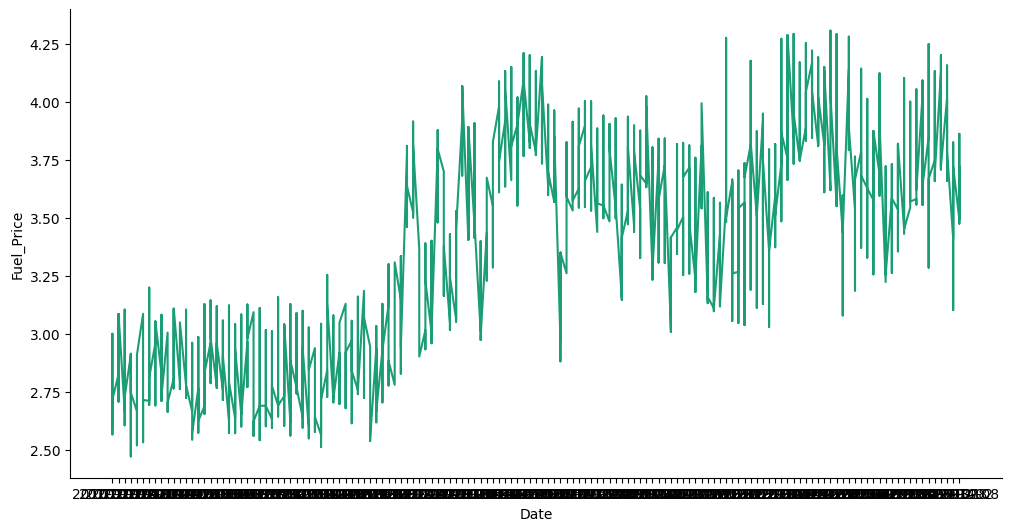

In [14]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Fuel_Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Fuel_Price')

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         180 non-null    int64  
 1   Date          180 non-null    object 
 2   Temperature   180 non-null    float64
 3   Fuel_Price    180 non-null    float64
 4   CPI           180 non-null    float64
 5   Unemployment  180 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.6+ KB


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Date          6255 non-null   object 
 2   Weekly_Sales  6255 non-null   float64
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   CPI           6255 non-null   float64
 6   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 342.2+ KB


In [17]:
train["Store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [18]:
def feature(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    return data

In [19]:
train = feature(train)
test = feature(test)

In [20]:
def split_and_index_by_store(data, store_column="Store", index_column="Date"):
    store_dfs = {}
    unique_stores = data[store_column].unique()

    for store in unique_stores:
        store_dfs[store] = data[data[store_column] == store].copy()
        store_dfs[store].set_index(index_column, inplace=True)

    return store_dfs

In [21]:
train_df_by_store = split_and_index_by_store(train)
test_df_by_store = split_and_index_by_store(test)

# модель для одного магазина и метрика

In [22]:
train = train_df_by_store[42].iloc[:-6]
test = train_df_by_store[42].iloc[-6:]

In [23]:
train_exog = train_df_by_store[42].iloc[:-6][["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]]
test_exog = train_df_by_store[42].iloc[-6:][["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]]

model_hw = ExponentialSmoothing(
    train["Weekly_Sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=12
)
hw_fit = model_hw.fit()

forecast_hw = hw_fit.forecast(steps=len(test))

mape_hw = mean_absolute_percentage_error(test["Weekly_Sales"], forecast_hw)

mape_hw

0.08332929351080536

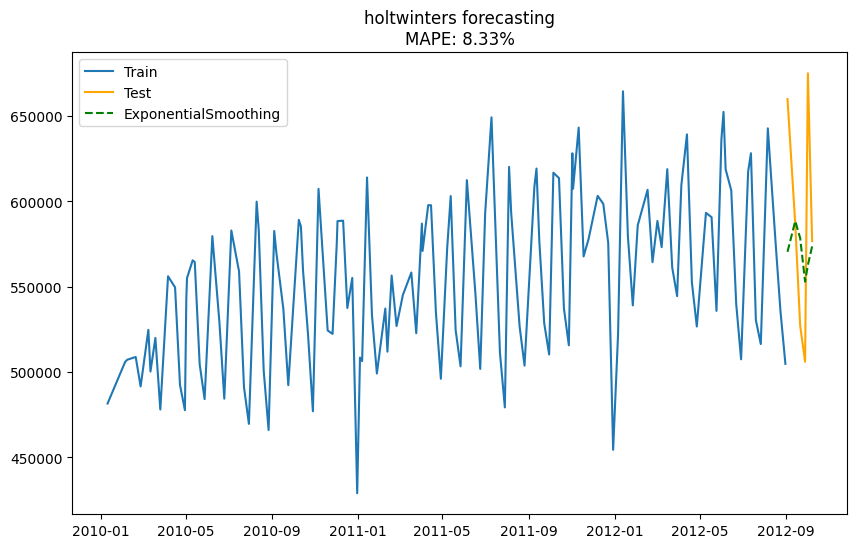

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train["Weekly_Sales"], label="Train")
plt.plot(test.index, test["Weekly_Sales"], label="Test", color="orange")
plt.plot(test.index, forecast_hw, label="ExponentialSmoothing", color="green", linestyle="--")
plt.legend()
plt.title(f"holtwinters forecasting\nMAPE: {mape_hw:.2%}")
plt.show()

In [27]:
ExponentialSmoothing_test = []
for i in range(1, 46):
    train = train_df_by_store[i]
    test = test_df_by_store[i]

    model = ExponentialSmoothing(
        train["Weekly_Sales"],
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    ExponentialSmoothing_fit = model.fit()

    forecast_ExponentialSmoothing = ExponentialSmoothing_fit.forecast(steps=len(test))
    ExponentialSmoothing_test.append(forecast_ExponentialSmoothing)

# Делаем сабмит файл

In [28]:
submit_data = []

for i, forecast in enumerate(ExponentialSmoothing_test, start=1):
    test_store = test_df_by_store[i]

    store_forecast = pd.DataFrame({
        "Weekly_Sales": forecast.values,
    })

    submit_data.append(store_forecast)

submit_df = pd.concat(submit_data, ignore_index=True)

submit_df["ID"] = submit_df.index

submit_df = submit_df[["ID", "Weekly_Sales"]]

submit_df.to_csv("submission.csv", index=False)